# Notebook to train VGG19 Classification Model

This Colab notebook will train the VGG19 classification model to classify the images present in the Intel Image dataset.

## Prerequisites (MANDATORY)

This section helps in getting the dataset from Kaggle. The dataset is available at the following link: 

https://www.kaggle.com/puneet6060/intel-image-classification

Get your own `kaggle.json` file using the following steps:

1. Sign in to your Kaggle account.
2. Go to **Account**, go to the **API** section.
3. Click on **Create New API Token** button.
4. The `kaggle.json` file is downloaded.
5. Initialize the runtime in this notebook, go to the **Flies** section on the left side of the notebook.
6. Right click and click on **Upload**, select the `kaggle.json` file and upload it.

Once that is done, run the following section to import the dataset.

**IMPORTANT: The `kaggle.json` file has to be uploaded every single time the runtime is restarted or recycled. Not doing so will result in failure to load the dataset.**

In [ ]:
pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
mkdir ~/.kaggle

In [ ]:
cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install git+https://github.com/google-research/tf-slim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/google-research/tf-slim to /tmp/pip-req-build-_v64v6ae
  Running command git clone -q https://github.com/google-research/tf-slim /tmp/pip-req-build-_v64v6ae
  Created wheel for tf-slim: filename=tf_slim-1.2.0-py3-none-any.whl size=360964 sha256=25d42ac2ac7596854c71429115d48eb11b0651e50725966bac3c26eaf3b89bce
  Stored in directory: /tmp/pip-ephem-wheel-cache-m3q3wctf/wheels/f4/84/2f/c5140718a49612b5ff335b62bb132d3020e9f7f307bcb3531a
Successfully built tf-slim


In [ ]:
!kaggle datasets download puneet6060/intel-image-classification

 98% 338M/346M [00:13<00:00, 18.6MB/s]
100% 346M/346M [00:13<00:00, 27.3MB/s]


In [ ]:
mkdir intel_images

In [ ]:
!unzip intel-image-classification.zip -d intel_images

Streaming output truncated to the last 5000 lines.
  inflating: intel_images/seg_train/seg_train/mountain/7506.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7537.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7539.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7551.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7560.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7565.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7578.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7581.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7586.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7647.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7652.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7654.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7662.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/767.jpg  
  inflating: intel_images/

The dataset is now available under a folder called `intel_images`. 

There are three parts to the dataset: training (`seg_train` folder), validation (`seg_test` folder), and prediction (`seg_pred` folder). 

This notebook will use the images in the `seg_train` folder to train the model and use the images in the `seg_test` folder to perform validation of the trained model.

In [ ]:
#!pip install wandb

## Importing and Path Settings (MANDATORY)

This section will import the packages necessary to run the code and identify the paths of the training, testing, and the prediction datasets.

In [ ]:
from time import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report 
import tensorflow as tf
from keras.preprocessing.image import load_img, ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.vgg19 import VGG19
#import wandb
#wandb.init()
start_time = time()
batch_size = 32
sns.set_style('darkgrid')

Paths for the training dataset, testing dataset, and the prediction dataset.

In [ ]:
PRED_FILES = "/content/intel_images/seg_pred/seg_pred"
TEST_FILES = "/content/intel_images/seg_test/seg_test"
TRAIN_FILES = "/content/intel_images/seg_train/seg_train"

## Train and Test Datasets Preprocessing (MANDATORY)

This section will create dataframes for the training and testing datasets. 

Creates a dataframe to map image to class in the training dataset.

In [ ]:
train_df = pd.DataFrame(columns=['file', 'label'])
for i in os.listdir(TRAIN_FILES):
    temp_df = pd.DataFrame({"file": os.listdir(f"{TRAIN_FILES}/{i}")})
    temp_df['label'] = temp_df["file"].apply(lambda x: i)
    train_df = train_df.append(temp_df)
train_df

,file,label
0,9209.jpg,mountain
1,9298.jpg,mountain
2,6638.jpg,mountain
3,12547.jpg,mountain
4,16991.jpg,mountain
...,...,...
2186,13901.jpg,buildings
2187,17156.jpg,buildings
2188,14182.jpg,buildings
2189,9404.jpg,buildings


Creates a dataframe to map image to class for the validation dataset.

In [ ]:
val_df = pd.DataFrame(columns=['file', 'label'])
for i in os.listdir(TEST_FILES):
    temp_df = pd.DataFrame({"file": os.listdir(f"{TEST_FILES}/{i}")})
    temp_df['label'] = temp_df["file"].apply(lambda x: i)
    val_df = val_df.append(temp_df)
val_df

,file,label
0,24283.jpg,mountain
1,21987.jpg,mountain
2,22191.jpg,mountain
3,20157.jpg,mountain
4,20613.jpg,mountain
...,...,...
432,22175.jpg,buildings
433,20425.jpg,buildings
434,23295.jpg,buildings
435,23757.jpg,buildings


Check the distribution of different labels in the train dataset.

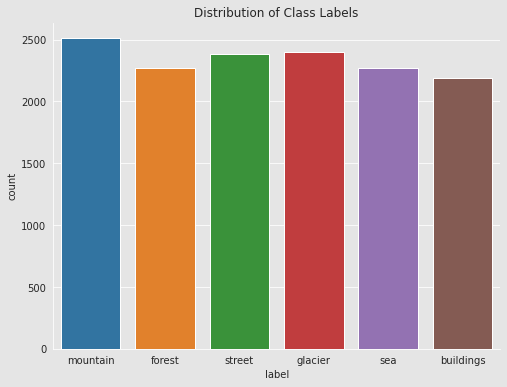

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6), facecolor = "#e5e5e5")
ax.set_facecolor("#e5e5e5")

sns.countplot(x = "label", data = train_df, ax = ax)

ax.set_title("Distribution of Class Labels")
sns.despine()
plt.show()

Check the distribution of different labels in the validation dataset.

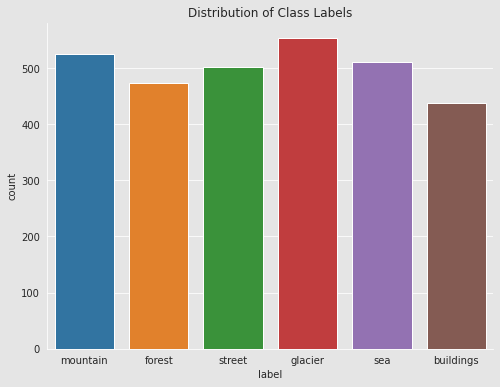

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6), facecolor = "#e5e5e5")
ax.set_facecolor("#e5e5e5")

sns.countplot(x = "label", data = val_df, ax = ax)

ax.set_title("Distribution of Class Labels")
sns.despine()
plt.show()

## Model definition (MANDATORY)

This section defines the VGG19 in the function  `vgg19_model_generator()`. The function can be called and the returned model can be stored into a variable.

Defines the VGG19 model.

In [ ]:
def vgg19_model_generator():
    base_model = VGG19(
        weights = "imagenet", 
        input_shape = (64, 64, 3),
        include_top = False)

    for layers in base_model.layers:
        layers.trainable = False

    model = Sequential([
        base_model, 
        GlobalAveragePooling2D(), 
        Dense(100, activation = "relu"), 
        Dropout(0.4), 
        Dense(64, activation = "relu"),
        Dense(6, activation = "softmax")
      ])
      
    return model

tf.keras.backend.clear_session()

## Generating the training and validation DataGenerator objects (MANDATORY)

Creating ImageDataGenerator objects for training and testing datasets.

In [ ]:
#1 Test Case - 1, only training set is data augmented
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    zoom_range=2.0,
    vertical_flip = True, 
    horizontal_flip = True,
    shear_range=0.2,
    preprocessing_function = preprocess_input
)

val_datagen = ImageDataGenerator(
    #rotation_range = 15, 
    #zoom_range=2.0,
    #horizontal_flip = True,
    #shear_range=0.2,
    preprocessing_function = preprocess_input
)

#2 Test Case 2: Both Training and test datasets are data augmented
'''
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    zoom_range=2.0,
    vertical_flip = True, 
    horizontal_flip = True,
    shear_range=0.2,
    preprocessing_function = preprocess_input
)

val_datagen = ImageDataGenerator(
    rotation_range = 15, 
    zoom_range=2.0,
    horizontal_flip = True,
    shear_range=0.2,
    preprocessing_function = preprocess_input
) '''

Creating training and validation generators for the training and validation datasets respectively.

In [ ]:
train_generator = train_datagen.flow_from_directory(
    directory = TRAIN_FILES,
    class_mode = "categorical",
    target_size = (64, 64),
    batch_size = batch_size,
    seed = 666
)

val_generator = val_datagen.flow_from_directory(
    directory = TEST_FILES,
    class_mode = "categorical",
    target_size = (64, 64),
    batch_size = batch_size,
    seed = 666
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


## Checkpoints and Model Compilation and Training (MANDATORY)

Creating checkpoints and defining learning rate reduction conditions.

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor = "val_accuracy", 
    patience = 2,
    verbose = 1, 
    factor = 0.5, 
    min_lr = 0.000000001
)

early_stopping = EarlyStopping(
    monitor = "val_accuracy",
    patience = 10,
    verbose = 1,
    mode = "max",
)

checkpoint = ModelCheckpoint(
    monitor = "val_accuracy",
    filepath = "intel_img_class_vgg16.{epoch:02d}-{val_accuracy:.6f}.hdf5",
    verbose = 1,
    save_best_only = True, 
    save_weights_only = True
)

Generating and compiling the model.

In [ ]:
model = vgg19_model_generator()
model_start = time()
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = "accuracy")

model.summary()



80150528/80134624 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 100)               51300     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                6464      
                                                                 
 dense_2 (Dense)             (None, 6)                 39

Fitting the model on the training data and validating with the validation data at every epoch.

In [ ]:
history = model.fit(
    train_generator,
    epochs = 20, 
    validation_data = val_generator,
    validation_steps = val_df.shape[0] // batch_size,
    steps_per_epoch = train_df.shape[0] // batch_size,
    callbacks = [reduce_lr, early_stopping, checkpoint]
)
model_end = time()

Epoch 1/20
438/438 [==============================] - ETA: 0s - loss: 2.1699 - accuracy: 0.3637
Epoch 1: val_accuracy improved from -inf to 0.64415, saving model to intel_img_class_vgg16.01-0.644153.hdf5
438/438 [==============================] - 46s 76ms/step - loss: 2.1699 - accuracy: 0.3637 - val_loss: 0.9250 - val_accuracy: 0.6442 - lr: 0.0010
Epoch 2/20
438/438 [==============================] - ETA: 0s - loss: 1.3592 - accuracy: 0.4629
Epoch 2: val_accuracy improved from 0.64415 to 0.70430, saving model to intel_img_class_vgg16.02-0.704301.hdf5
438/438 [==============================] - 33s 76ms/step - loss: 1.3592 - accuracy: 0.4629 - val_loss: 0.7627 - val_accuracy: 0.7043 - lr: 0.0010
Epoch 3/20
438/438 [==============================] - ETA: 0s - loss: 1.2530 - accuracy: 0.5110
Epoch 3: val_accuracy improved from 0.70430 to 0.72849, saving model to intel_img_class_vgg16.03-0.728495.hdf5
438/438 [==============================] - 33s 75ms/step - loss: 1.2530 - accuracy: 0.5110

## Accuracy metrics graphed (MANDATORY)

Graphing the accuracy metrics of the model throughout the training process.

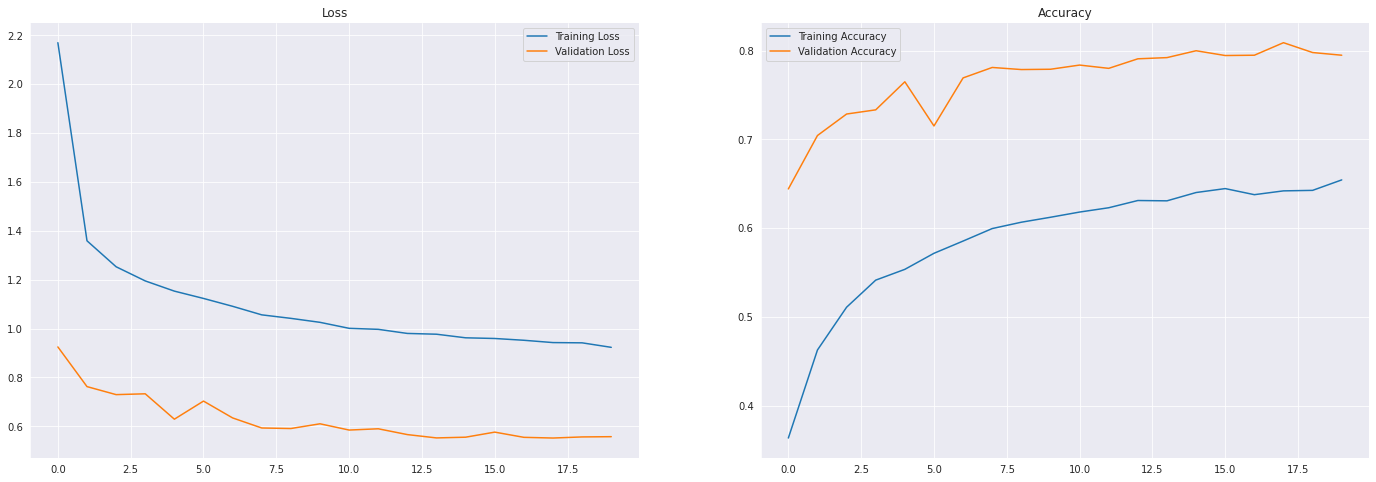

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (24, 8))

sns.lineplot(x = range(len(history.history["loss"])), y = history.history["loss"], ax = axes[0], label = "Training Loss")
sns.lineplot(x = range(len(history.history["loss"])), y = history.history["val_loss"], ax = axes[0], label = "Validation Loss")

sns.lineplot(x = range(len(history.history["accuracy"])), y = history.history["accuracy"], ax = axes[1], label = "Training Accuracy")
sns.lineplot(x = range(len(history.history["accuracy"])), y = history.history["val_accuracy"], ax = axes[1], label = "Validation Accuracy")
axes[0].set_title("Loss"); axes[1].set_title("Accuracy")

sns.despine()
plt.show()

In [ ]:
print(f"Model execution time = {model_end - model_start}")
print(f"Overall execution = {time() - start_time}")

Model execution time = 757.6340615749359
Overall execution = 1033.1312997341156
